In [1]:
import argparse
import os
import numpy as np
import time
import cv2
import pandas as pd
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt

from dataset import *
from model import *
from utils import *
from scipy.special import softmax
class_num = 4 #cat dog person background

num_epochs = 30
batch_size = 32


boxs_default = default_box_generator([10,5,3,1], [0.2,0.4,0.6,0.8], [0.1,0.3,0.5,0.7])


#Create network
network = SSD(class_num)
network.cuda()
cudnn.benchmark = True

/home/mka219/.conda/envs/image_segmentation/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_test = COCO("data/train/images/", "data/train/annotations/", class_num, boxs_default, train = False, image_size=320)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=0)

Validation


In [3]:
network.load_state_dict(torch.load('network_3feb.pth'))
network.eval()
len(dataloader_test)

639

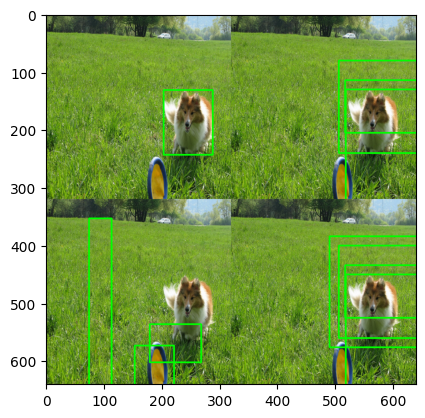

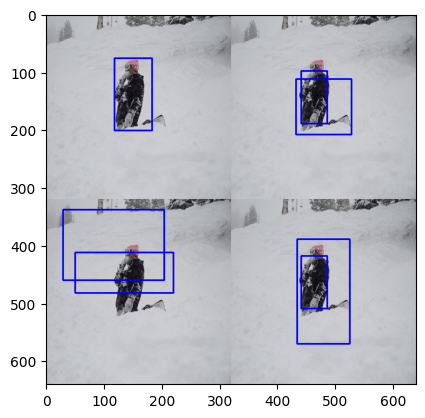

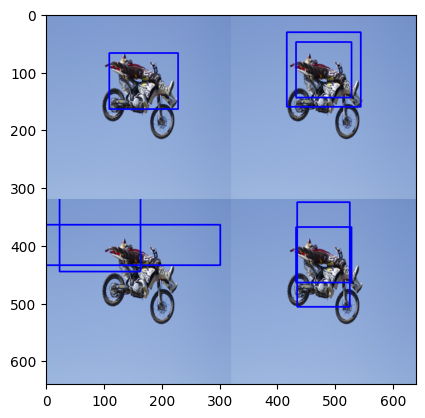

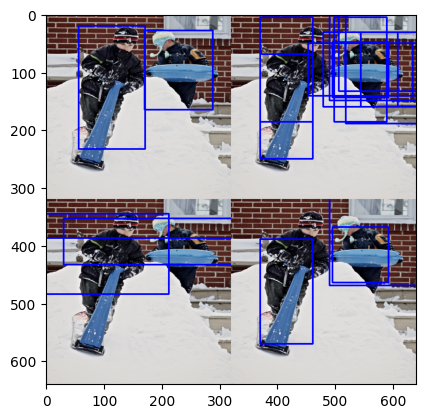

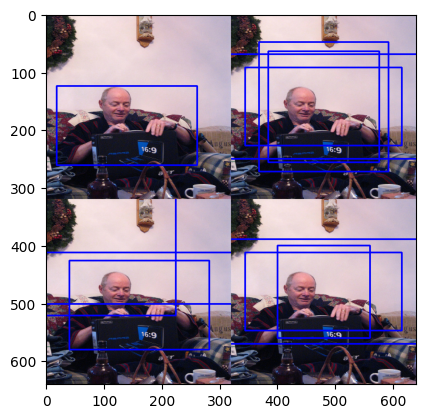

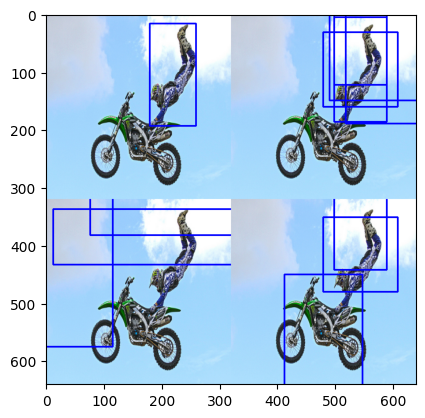

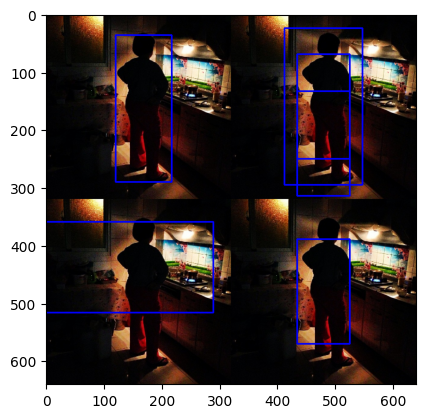

In [4]:
dataframes_list = [pd.DataFrame(), pd.DataFrame(), pd.DataFrame()]
for i, data in enumerate(dataloader_test, 0):
    images_, ann_box_, ann_confidence_,val_gt_info = data
    images = images_.cuda()
    ann_box = ann_box_.cuda()
    ann_confidence = ann_confidence_.cuda()
    #print(images.shape)
    pred_confidence, pred_box = network(images)

    pred_confidence_ = pred_confidence[0].detach().cpu().numpy()
    pred_box_ = pred_box[0].detach().cpu().numpy()
    #print(pred_box_[0])
    pred_confidence_,pred_box_, ogn_pred_box = non_maximum_suppression(pred_confidence_,pred_box_,boxs_default)
    #print(pred_box_[0])
    #TODO: save predicted bounding boxes and classes to a txt file.
    #you will need to submit those files for grading this assignment
    if i%99==0:
        visualize_pred("test", pred_confidence_, pred_box_, ann_confidence_[0].numpy(), ann_box_[0].numpy(), images_[0].numpy(), boxs_default, ogn_pred_box)
    #print(pred_box_[0])
    f_val_gt_info = []
    for j in range(len(val_gt_info)):
        t=[]
        for k in val_gt_info[j]:
            t.append(k.numpy()[0])
        f_val_gt_info.append(t)
    map_output = generate_mAP(pred_confidence_, pred_box_, boxs_default, f_val_gt_info)
    for l in range(len(map_output)):
        dataframes_list[l]= pd.concat((dataframes_list[l], map_output[l]))

    #if i==50:
        #break
    

In [5]:
classcount = dataset_test.get_count()

In [6]:
classcount

[106, 80, 507]

In [7]:
import matplotlib.pyplot as plt

<Figure size 640x480 with 0 Axes>

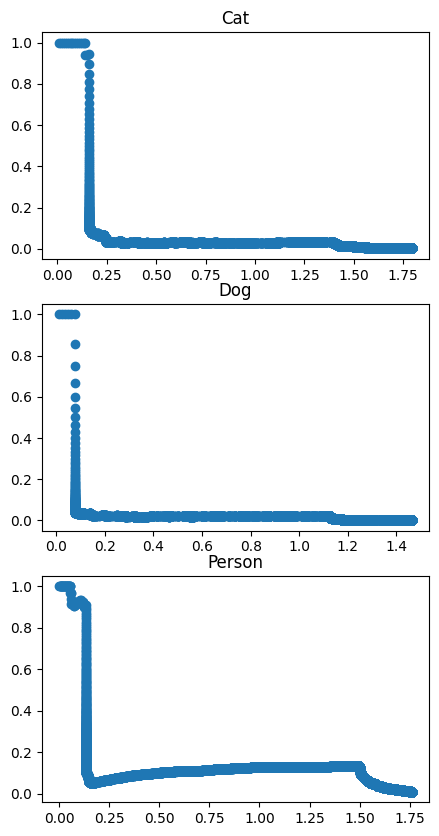

The mAP is  0.1969335168375682


In [10]:
fig = plt.figure()
#ax = [fig.add_subplot(111), fig.add_subplot(211), fig.add_subplot(311)]
fig, axs = plt.subplots(3,figsize=(5, 10))
area_list = []
labels = ["Cat", "Dog", "Person"]
for i in range(len(dataframes_list)):
        #print(i)
        dataframes_list[i] = dataframes_list[i].sort_values(0, ascending=False)
        dataframes_list[i] = dataframes_list[i].iloc[:int((dataframes_list[i].shape[0])*0.5),:]
        dataframes_list[i]["Acctp"]=dataframes_list[i][1].cumsum()
        dataframes_list[i]["Accfp"]=dataframes_list[i][2].cumsum()
        dataframes_list[i]["precision"]=dataframes_list[i]['Acctp']/(dataframes_list[i]["Acctp"]+dataframes_list[i]["Accfp"])
        dataframes_list[i]["recall"]=dataframes_list[i]["Acctp"]/(classcount[i])
        precision = list(dataframes_list[i]["precision"])
        recall = list(dataframes_list[i]["recall"])
        #print(max(recall))
        area = 0
        for j in range(len(recall)):
                if j==0:
                        area = area + (recall[j])*precision[j]
                else:
                        area = area + (recall[j]-recall[j-1])*precision[j]
        area_list.append(area)
        #print(max(recall))
        axs[i].scatter(recall, precision)
        axs[i].set_title(labels[i])
plt.show()
print("The mAP is ", sum(area_list)/len(area_list))

In [11]:
area_list

[0.20391404968801452, 0.09893410078051951, 0.2879524000441706]

In [ ]:
df = dataframes_list[1]
print(df)

                0    1    2  Acctp    Accfp  precision    recall
458  5.330620e-01  0.0  1.0    0.0      1.0   0.000000  0.000000
520  5.327651e-01  0.0  1.0    0.0      2.0   0.000000  0.000000
458  5.242900e-01  0.0  1.0    0.0      3.0   0.000000  0.000000
425  5.152198e-01  0.0  1.0    0.0      4.0   0.000000  0.000000
535  5.075139e-01  0.0  1.0    0.0      5.0   0.000000  0.000000
..            ...  ...  ...    ...      ...        ...       ...
324  2.282677e-21  0.0  1.0    2.0  27534.0   0.000073  0.142857
136  1.635905e-21  0.0  1.0    2.0  27535.0   0.000073  0.142857
348  8.160025e-22  0.0  1.0    2.0  27536.0   0.000073  0.142857
352  2.260173e-22  0.0  1.0    2.0  27537.0   0.000073  0.142857
324  1.922418e-22  0.0  1.0    2.0  27538.0   0.000073  0.142857

[27540 rows x 7 columns]


In [ ]:
a = np.array([[1, 2], [3, 4]])
b = np.array([[5, 6]])

In [ ]:
import numpy as np

In [ ]:
np.ran

In [ ]:
t= np.array([[12,23,45], [56, 78, 23], [56,23,6]])

In [ ]:
t

array([[12, 23, 45],
       [56, 78, 23],
       [56, 23,  6]])

In [ ]:
t1 = pd.DataFrame(t)
t2 = pd.DataFrame(t)

In [ ]:
t1

,0,1,2
0,12,23,45
1,56,78,23
2,56,23,6


In [ ]:
def generate_mAP(pred_confidence, pred_box, boxs_default, val_gt_info, overlap=0.5, threshold=0.5):
    #TODO: Generate mAP
    num_classes=3
    #val_gt_info = val_gt_info.reshape(val_gt_info.shape[0]*val_gt_info.shape[1], val_gt_info.shape[2])
    #ann_box = ann_box.reshape(ann_box.shape[0]*ann_box.shape[1], ann_box.shape[2])
    #pred_box = pred_box.reshape(pred_box.shape[0]*pred_box.shape[1], pred_box.shape[2])
    #ann_confidence = ann_confidence.reshape(ann_confidence.shape[0]*ann_confidence.shape[1], ann_confidence.shape[2])
    #pred_confidence = pred_confidence.reshape(pred_confidence.shape[0]*pred_confidence.shape[1], pred_confidence.shape[2])
    #val_gt_info = val_gt_info.reshape(val_gt_info.shape[0]*val_gt_info.shape[1], val_gt_info.shape[2])
    dataframes_list = [pd.DataFrame(), pd.DataFrame(), pd.DataFrame()]
    #score_list = []
    #print(val_gt_info)
    pred_confidence = softmax(pred_confidence, axis=1)
    for i in range(len(pred_box)):
        pred_box[i][0] = boxs_default[i][2]*pred_box[i][0] + boxs_default[i][0]
        pred_box[i][1] = boxs_default[i][3]*pred_box[i][1] + boxs_default[i][1]
        pred_box[i][2] = boxs_default[i][2]*math.exp(pred_box[i][2])
        pred_box[i][3] = boxs_default[i][3]*math.exp(pred_box[i][3])
    #print(pred_confidence[0])
    for i in range(num_classes):
        obj_ind = np.where(pred_confidence[:,i]!=0)
        #print(len(obj_ind[0]))
        obj_true_positive = np.zeros(len(obj_ind[0]), np.float32)
        obj_false_positive = np.zeros(len(obj_ind[0]), np.float32)
        obj_pred_box = pred_box[obj_ind]
        
        obj_pred_confidence = pred_confidence[obj_ind][:,i]
        #obj_val_gt_info = val_gt_info
        for j in range(len(obj_pred_box)):
            one_t_one_check = 0 
            i_cls_count = 0
            for line in val_gt_info:
                class_id = line[0]
                org_height = line[5]
                org_width = line[6]
                gx = line[1]/ org_width
                gy = line[2]/ org_height
                gw = line[3]/ org_width
                gh = line[4]/ org_height
                x_min = gx 
                y_min = gy 
                x_max = gx+gw 
                y_max = gy+gh

                
                if obj_pred_confidence[j]>0.5:
                    #print("GT X_MIN ", class_id, x_min, y_min, x_max, y_max)
                    pred_box_single = np.array([[obj_pred_box[j][0], obj_pred_box[j][1], obj_pred_box[j][2], obj_pred_box[j][3], 
                      obj_pred_box[j][0]-(obj_pred_box[j][2]/2), obj_pred_box[j][1]-(obj_pred_box[j][3]/2), 
                      obj_pred_box[j][0]+(obj_pred_box[j][2]/2), obj_pred_box[j][1]+(obj_pred_box[j][3]/2)]]) 
                    #print("PT X_MIN ",class_id, obj_pred_box[j][0]-(obj_pred_box[j][2]/2), obj_pred_box[j][1]-(obj_pred_box[j][3]/2), 
                      #obj_pred_box[j][0]+(obj_pred_box[j][2]/2), obj_pred_box[j][1]+(obj_pred_box[j][3]/2))
                else:
                    pred_box_single = np.array([[obj_pred_box[i][0], obj_pred_box[i][1], obj_pred_box[i][2], obj_pred_box[i][3], 
                      obj_pred_box[j][0]-(obj_pred_box[j][2]/2), obj_pred_box[j][1]-(obj_pred_box[j][3]/2), 
                      obj_pred_box[j][0]+(obj_pred_box[j][2]/2), obj_pred_box[j][1]+(obj_pred_box[j][3]/2)]]) 
                    
                ious = iou(pred_box_single, x_min,y_min,x_max,y_max)
                if ious>overlap:
                    #print("came")
                    one_t_one_check = one_t_one_check+1
                    if i==class_id:
                        i_cls_count = i_cls_count + 1
            
            if one_t_one_check==1 and len(val_gt_info)==1 and i_cls_count==1:
                #print(one_t_one_check, len(val_gt_info), i_cls_count)
                obj_true_positive[j] = 1
            else:
                obj_false_positive[j] = 1
        #print(obj_pred_confidence.shape, obj_true_positive.shape, obj_false_positive.shape)
        
        t_df = np.column_stack((obj_pred_confidence, obj_true_positive, obj_false_positive))
                
        #t_df = np.concatenate((obj_pred_box, obj_pred_confidence), axis=1)
        dataframes_list[i]= pd.concat((dataframes_list[i], pd.DataFrame(t_df)))
    return dataframes_list


In [ ]:
t2

,0,1,2
0,12,23,45
1,56,78,23
2,56,23,6


In [ ]:
p=pd.DataFrame()


In [ ]:
pd.concat((p,t1))

,0,1,2
0,12,23,45
1,56,78,23
2,56,23,6


In [ ]:
p.append(t2)

/tmp/ipykernel_35300/4074193920.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p.append(t2)


,0,1,2
0,12,23,45
1,56,78,23
2,56,23,6
